# Creating a model for classifying toxic texts.

**Description**

- The purpose of the work is to train a binary classification model that can determine whether a text is toxic or not.  
- The Keggle dataset will be used as a training dataset.  
- Lemmatization of the text will be carried out using the nltk library.
- The preparation of features from the text will be carried out by the TF-IDF method.  
- As a model, let's try gradient boosting (CatBoost) and a naive bayes model.  
- The saved trained model will be deployed to the streamlit site as an interactive web application.

**References**

- Train dataset: https://www.kaggle.com/datasets/ashwiniyer176/toxic-tweets-dataset?resource=download

## Imports

In [1]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import re

from collections import Counter
from itertools import chain

import nltk
nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
from nltk import WordNetLemmatizer
from nltk import pos_tag, word_tokenize
from nltk.corpus import stopwords as nltk_stopwords
from nltk.corpus import wordnet


from sklearn.feature_extraction.text import TfidfVectorizer

from catboost import CatBoostClassifier

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import MultinomialNB

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## Loading data

In [3]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df = pd.read_csv('/content/drive/MyDrive/Datasets/toxic_tweet_db.csv', index_col=0)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56745 entries, 0 to 56744
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Toxicity  56745 non-null  int64 
 1   tweet     56745 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.3+ MB


In [6]:
print(f"{round(df['Toxicity'].mean()*100, 2)}% texts is toxic.")

42.56% texts is toxic.


## Data preparation

Let's state a preparation function and lemmatizer variable

In [7]:
wnl = WordNetLemmatizer()

In [8]:
def prepare_text(text):
    def get_wordnet_pos(treebank_tag):
        if treebank_tag.startswith('J'):
            return wordnet.ADJ
        elif treebank_tag.startswith('V'):
            return wordnet.VERB
        elif treebank_tag.startswith('N'):
            return wordnet.NOUN
        elif treebank_tag.startswith('R'):
            return wordnet.ADV
        else:
            return wordnet.NOUN
    text = re.sub(r'[^a-zA-Z\']', ' ', text)
    text = text.split()
    text = ' '.join(text)
    text = word_tokenize(text)
    text = pos_tag(text)
    lem = []
    for i in text: lem.append(wnl.lemmatize(i[0], pos = get_wordnet_pos(i[1])))
    lem = ' '.join(lem)
    return lem

In [9]:
%%time
df['tweet_lem'] = df['tweet'].apply(lambda x: prepare_text(x))

CPU times: user 1min 19s, sys: 1.3 s, total: 1min 20s
Wall time: 1min 27s


In [10]:
df.sample(3)

,Toxicity,tweet,tweet_lem
17306,0,@user more people care about shark week than ...,user more people care about shark week than bl...
42700,1,I love you my nigguh but your a grown ass man ...,I love you my nigguh but your a grown as man h...
30726,0,the #boston globe's full front page features a...,the boston globe 's full front page feature an...


## TF-IDF

In [11]:
%%time
corpus = df['tweet_lem'].values.astype('U')
stopwords = set(nltk_stopwords.words('english'))

count_tf_idf = TfidfVectorizer(stop_words=stopwords)
tf_idf = count_tf_idf.fit_transform(corpus)

pickle.dump(count_tf_idf, open('tf_idf.pkt', 'wb'))

print("Matrix shape:", tf_idf.shape)

Matrix shape: (56745, 58409)
CPU times: user 1.06 s, sys: 41.9 ms, total: 1.1 s
Wall time: 1.11 s


## Model Selection

In [12]:
tf_idf_train, tf_idf_test, target_train, target_test = train_test_split(
    tf_idf, df['Toxicity'], test_size=0.25, random_state=42, shuffle=True)

### CatBoost

In [13]:
params = {
'loss_function' : 'Logloss',
'custom_loss' : 'AUC:hints=skip_train~false',
'eval_metric' : 'AUC:hints=skip_train~false',
'verbose' : 200,
'random_seed' : 42,
'depth': 4,
'learning_rate': 0.4
}

In [14]:
model_cat = CatBoostClassifier(**params)

In [15]:
%%time
model_cat.fit(tf_idf_train, target_train)

0:	learn: 0.8360787	total: 261ms	remaining: 4m 20s
200:	learn: 0.9885480	total: 36.7s	remaining: 2m 25s
400:	learn: 0.9952881	total: 1m 11s	remaining: 1m 46s
600:	learn: 0.9972670	total: 1m 46s	remaining: 1m 10s
800:	learn: 0.9981505	total: 2m 22s	remaining: 35.3s
999:	learn: 0.9988460	total: 2m 56s	remaining: 0us
CPU times: user 5min 9s, sys: 2.22 s, total: 5min 11s
Wall time: 3min 1s


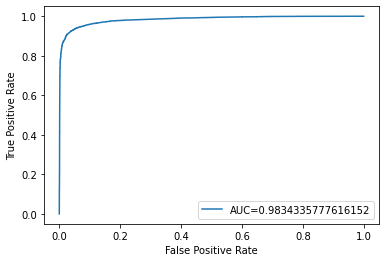

In [16]:
y_pred_proba = model_cat.predict_proba(tf_idf_test)[::,1]
fpr, tpr, _ = roc_curve(target_test,  y_pred_proba)
final_roc_auc = roc_auc_score(target_test, y_pred_proba)

plt.plot(fpr,tpr,label="AUC="+str(final_roc_auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [17]:
sample = 'I hate you'
sample_tfidf = count_tf_idf.transform([sample])
display(model_cat.predict_proba(sample_tfidf))
display(model_cat.predict(sample_tfidf))

array([[0.90574787, 0.09425213]])

array([0])

### Naive Bayes

In [18]:
model_bayes = MultinomialNB()

In [19]:
model_bayes.fit(tf_idf_train, target_train)

MultinomialNB()

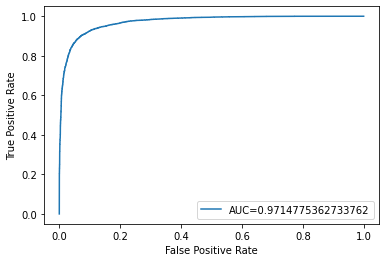

In [20]:
y_pred_proba = model_bayes.predict_proba(tf_idf_test)[::,1]
fpr, tpr, _ = roc_curve(target_test,  y_pred_proba)
final_roc_auc = roc_auc_score(target_test, y_pred_proba)

plt.plot(fpr,tpr,label="AUC="+str(final_roc_auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [21]:
sample = 'I hate you'
sample_tfidf = count_tf_idf.transform([sample])
display(model_bayes.predict_proba(sample_tfidf))
display(model_bayes.predict(sample_tfidf))

array([[0.29246642, 0.70753358]])

array([1])

## Fitting and saving best model

Manual verification of the models showed that the naive bayes model is more suitable for our task.

In [22]:
model = MultinomialNB()
model.fit(tf_idf,  df['Toxicity'])
pickle.dump(model, open('model.pkt', 'wb'))